# Applying Advanced Machine Learning Algorithms to Dog Disease Predictions

In [ ]:
# VERSION SET UP
# need to set some versions
import sys 
!pip install imblearn

# For Google Colab:
# Mounting drive to access datafile
# from google.colab import drive
# drive.mount('/content/drive')

# for Google Workbook:
!{sys.executable} -m pip install --user pandas==1.1.5
!{sys.executable} -m pip install --user tensorflow==1.13.1 # 1.15.0 # paper said us 1.10.0, but it doesn't exist???
!{sys.executable} -m pip install --user numpy==1.19.5  # this one breaks on the tensor to numpy issue: 1.16.0 # tested with 1.16.0 # paper said us 1.15.3, but too many dependency conflicts
!{sys.executable} -m pip install --user hmmlearn


# for other environments:
# !{sys.executable} -m pip install pandas==1.1.5
# !{sys.executable} -m pip install tensorflow==1.13.1 # 1.15.0 # paper said us 1.10.0, but it doesn't exist???
# !{sys.executable} -m pip install numpy==1.19.5  # this one breaks on the tensor to numpy issue: 1.16.0 # tested with 1.16.0 # paper said us 1.15.3, but too many dependency conflicts
# !{sys.executable} -m pip install hmmlearn

# may have to restart kernel after running these to get access to them

In [2]:
#Importing/installing modules
from __future__ import absolute_import, division, print_function

import collections
import hashlib
import numbers
import itertools
import functools
import inspect
import pickle

import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
get_ipython().magic('matplotlib inline')

import warnings
warnings.filterwarnings("ignore")

import os
from pathlib import Path
import shutil

import tensorflow as tf
from tensorflow.contrib.rnn import PhasedLSTMCell, MultiRNNCell, BasicRNNCell
from tensorflow.python.ops import rnn_cell, rnn
from tensorflow.python.eager import context
from tensorflow.python.framework import constant_op, dtypes, ops, tensor_shape, tensor_util   
from tensorflow.python.layers import base as base_layer
from tensorflow.python.ops import * 
from tensorflow.python.platform import tf_logging as logging
from tensorflow.python.training import checkpointable
from tensorflow.python.util import nest
from tensorflow.python.util.tf_export import tf_export

from sklearn.model_selection import *
from sklearn.metrics import *
from sklearn.preprocessing import StandardScaler, MinMaxScaler
# from sklearn.metrics import accuracy_score
# from sklearn.metrics import mean_absolute_error
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture
from scipy.stats import multivariate_normal
from hmmlearn import hmm

# pipelines
from imblearn.pipeline import Pipeline
from sklearn.pipeline import Pipeline
from sklearn import set_config # used to display pipeline diagram

# Model Code
from timegan import timegan, discriminative_score_metrics,  predictive_score_metrics, doggo_data_timeGANs, prep_synth_data, oversamp_minority_data
from assm import attentive_state_space_model, generate_doggo_trajectory, generate_doggo_trajectory_syn, generate_doggo_trajectory_comb, HMM

# Evaluation
from metrics import PCA_Analysis, tSNE_Analysis

# Data Processing
from data_proc import doggo_data_loading
import time

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

In [3]:
# version checks
# Python version
# Python version - should be 3.6 or could have issues
print('Python:',sys.version_info, '\n')

pd_check = pd.__version__=='1.1.5'
np_check = np.__version__=='1.19.5'
tf_check = tf.__version__=='1.13.1'
print('Pandas version correct', pd_check)
print('Numpy version correct', np_check)
print('TensorFlow version correct', tf_check)
if(pd_check == True and np_check == True and tf_check == True):
    print("\nVersions all correct")
else:
    print("""
    A key version of these libraries is set to the wrong version.
    Run the appropriate VERSION SET UP settings above and then restart kernel.
            """)



Python: sys.version_info(major=3, minor=7, micro=12, releaselevel='final', serial=0) 

Pandas version correct True
Numpy version correct True
TensorFlow version correct True

Versions all correct


In [4]:
seqlen = 4

start_time = time.time()

gan_df, gan_feat_list = doggo_data_loading(seq_length=seqlen, apply_seq_length=True)
dataX = doggo_data_timeGANs(gan_df, seq_length=seqlen)

elapsed_time = time.time() - start_time
print(f"Elapsed time to pull up data: {elapsed_time:.3f} seconds")

feature size:  42
Joined SIZE:  (49425, 47)
doggo_data_timeGANs dataframe shape post:  (49425, 42)
Elapsed time to pull up data: 10.423 seconds


# Time-series Generative Adversarial Networks

In [5]:
## Main Parameters
# Experiments iterations
Iteration = 2 # started with: 1
Sub_Iteration = 3 # started with: 2

## Newtork Parameters
parameters = dict()

parameters['hidden_dim'] = len(dataX[0][0,:]) * 4
parameters['num_layers'] = 3 # started with: 2 (has to be at least 2!)
parameters['iterations'] = 10000 # started with: 1000, low as 10
parameters['batch_size'] = 128 # started with: 64, low as 2
parameters['module_name'] = 'gru'   # Other options: 'lstm' or 'lstmLN'
parameters['z_dim'] = len(dataX[0][0,:]) 

print('Parameters are ' + str(parameters))

## Experiments
# Output Initialization
Discriminative_Score = list()
Predictive_Score = list()

Parameters are {'hidden_dim': 168, 'num_layers': 3, 'iterations': 10000, 'batch_size': 128, 'module_name': 'gru', 'z_dim': 42}


In [6]:
# Run TimeGANs model
print('Start iterations') 
start_time = time.time()

# Each Iteration
for it in range(Iteration):

    # Synthetic Data Generation
    dataX_hat = timegan(dataX, parameters)   

    print('Finish Synthetic Data Generation')
    elapsed_time = time.time() - start_time
    print(f"Elapsed time to Finish Synthetic Data Generation: {elapsed_time:.3f} seconds")

    ## Performance Metrics
    
    # 1. Discriminative Score
    Acc = list()
    for tt in range(Sub_Iteration):
        Temp_Disc = discriminative_score_metrics (dataX, dataX_hat)
        Acc.append(Temp_Disc)
    
    elapsed_time = time.time() - start_time
    print(f"Elapsed time to pull up Discriminative Score: {elapsed_time:.3f} seconds")
    
    Discriminative_Score.append(np.mean(Acc))
    
    # 2. Predictive Performance
    MAE_All = list()
    for tt in range(Sub_Iteration):
        # print(f'min data solvency check predictive score metrics length: {len(predictive_score_metrics(dataX_min, dataX_hat_min))}')
        print(f'min data solvency check predictive score metrics: {predictive_score_metrics}')
        MAE_All.append(predictive_score_metrics (dataX, dataX_hat))
    
    elapsed_time = time.time() - start_time
    print(f"Elapsed time to pull up Predictive Performance: {elapsed_time:.3f} seconds")
        
    Predictive_Score.append(np.mean(MAE_All))    
    
print('Finish TimeGAN iterations')
elapsed_time = time.time() - start_time
print(f"Elapsed time FINAL: {elapsed_time:.3f} seconds")

Start iterations
Instructions for updating:
This class is equivalent as tf.keras.layers.GRUCell, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
This class is equivalent as tf.keras.layers.StackedRNNCells, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Start Embedding Network Training
step: 0, e_loss: 0.4172
step: 1000, e_loss: 0.2605
step: 2000, e_loss: 0.246
step: 3000, e_loss: 0.2265
step: 4000, e_loss: 0.2016
step: 5000, e_loss: 0.1869
step: 6000, e_loss: 0.1559
step: 7000, e_loss: 0.1374
step: 8000, e_loss: 0.1177
step: 9000, e_loss: 0.0973
Finish Embedding Network Training
Start Training with Supervised Loss Only
step: 0, s_loss: 0.3086
step: 1000, s_loss: 0.0305
step: 2000, s_loss: 0.0242
ste

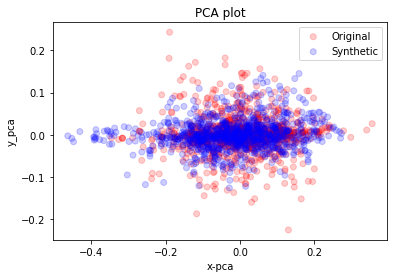

In [7]:
PCA_Analysis (dataX, dataX_hat)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 2000 samples in 0.002s...
[t-SNE] Computed neighbors for 2000 samples in 0.068s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2000
[t-SNE] Computed conditional probabilities for sample 2000 / 2000
[t-SNE] Mean sigma: 0.014420
[t-SNE] KL divergence after 250 iterations with early exaggeration: 64.729492
[t-SNE] KL divergence after 300 iterations: 1.045999


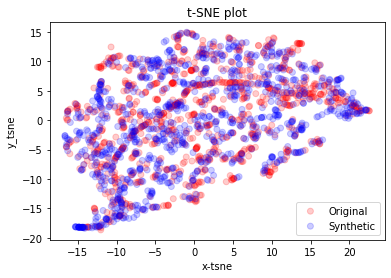

In [8]:
tSNE_Analysis (dataX, dataX_hat)

In [9]:
# Print Results
print('Discriminative Score - Mean: ' + str(np.round(np.mean(Discriminative_Score),4)) + ', Std: ' + str(np.round(np.std(Discriminative_Score),4)))
print('Predictive Score - Mean: ' + str(np.round(np.mean(Predictive_Score),4)) + ', Std: ' + str(np.round(np.std(Predictive_Score),4)))

Discriminative Score - Mean: 0.4924, Std: 0.0052
Predictive Score - Mean: 0.0839, Std: 0.0


# DISEASE TRAJECTORY STATE PREDICTIONS

In [35]:
## Data Loading
seqlen = 4

start_time = time.time()

# generate the data
assm_df, assm_feat_list = doggo_data_loading(seq_length=seqlen, apply_seq_length=True) 
feat_num = len(assm_feat_list)

elapsed_time = time.time() - start_time
print(f"Elapsed time to pull up data: {elapsed_time:.3f} seconds")

X_observations, true_states = generate_doggo_trajectory(assm_df[0:17000], feats=assm_feat_list)
elapsed_time = time.time() - start_time
print(f"Elapsed time to massage data: {elapsed_time:.3f} seconds")


feature size:  42
Joined SIZE:  (49425, 47)
Elapsed time to pull up data: 10.110 seconds
Elapsed time to massage data: 14.536 seconds


In [11]:
trajectory_index = 1

true_states[trajectory_index]

[0.0, 0.0, 1.0, 1.0, 1.0, 1.0]

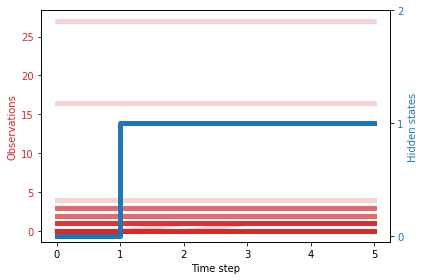

In [12]:
# Visualizing the hidden state data trajectories
fig, ax1 = plt.subplots()

t = list(range(len(true_states[trajectory_index])))

color = 'tab:red'
ax1.set_xlabel('Time step')
ax1.set_ylabel('Observations', color=color)
ax1.plot(t, X_observations[trajectory_index], color=color, linewidth=5, alpha=0.2)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  

color = 'tab:blue'
ax2.set_ylabel('Hidden states', color=color)  
ax2.step(t, true_states[trajectory_index], color=color, linewidth=5)
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_yticks([0, 1, 2])

fig.tight_layout()  
plt.show()

In [13]:
model = attentive_state_space_model(num_states=4,
                              maximum_seq_length=30, 
                              input_dim=feat_num, # 6, # started with: 6. tried 10, but broke, but that was original, adjust for how many features used in data
                              rnn_type='LSTM',
                              latent=True,
                              generative=True,
                              num_iterations=50,   # started with: 5
                              num_epochs=3, # 3,  # started with: 2
                              batch_size=100, # 100,  # started with: 10
                              learning_rate=5*1e-4, 
                              num_rnn_hidden=100, # 100,  # started with: 5
                              num_rnn_layers=1,
                              dropout_keep_prob=None,
                              num_out_hidden=100,  # started with: 5
                              num_out_layers=1)

Instructions for updating:
This class is equivalent as tf.keras.layers.SimpleRNNCell, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
This class is equivalent as tf.keras.layers.LSTMCell, and will be replaced by that in Tensorflow 2.0.


In [14]:
start_time = time.time()

model.fit(X_observations)

elapsed_time = time.time() - start_time
print(f"Elapsed time to run ASSM model: {elapsed_time:.3f} seconds")

TensorFlow version : >= 1.0
---------------------------
Instructions for updating:
Please use `keras.layers.RNN(cell, unroll=True)`, which is equivalent to this API
Epoch 0 	----- 	Batch 0 	----- 	Log-Likelihood -1.066476e+11
Epoch 0 	----- 	Batch 1 	----- 	Log-Likelihood -1.146160e+11
Epoch 0 	----- 	Batch 2 	----- 	Log-Likelihood -1.089387e+11
Epoch 0 	----- 	Batch 3 	----- 	Log-Likelihood -1.225972e+11
Epoch 0 	----- 	Batch 4 	----- 	Log-Likelihood -1.094825e+11
Epoch 0 	----- 	Batch 5 	----- 	Log-Likelihood -1.186691e+11
Epoch 0 	----- 	Batch 6 	----- 	Log-Likelihood -1.126389e+11
Epoch 0 	----- 	Batch 7 	----- 	Log-Likelihood -1.094905e+11
Epoch 0 	----- 	Batch 8 	----- 	Log-Likelihood -1.105401e+11
Epoch 0 	----- 	Batch 9 	----- 	Log-Likelihood -1.021359e+11
Epoch 0 	----- 	Batch 10 	----- 	Log-Likelihood -1.089099e+11
Epoch 0 	----- 	Batch 11 	----- 	Log-Likelihood -1.103685e+11
Epoch 0 	----- 	Batch 12 	----- 	Log-Likelihood -1.069167e+11
Epoch 0 	----- 	Batch 13 	----- 	Log-Li

In [15]:
model.initial_probabilities

array([0.98833394, 0.01166606])

In [16]:
model.transition_matrix

array([[1., 0.],
       [0., 1.]])

In [17]:
model.state_means.T 

array([[2.41592762e+00, 2.24352332e+00],
       [3.61883221e-02, 0.00000000e+00],
       [2.22409380e+00, 2.27461140e+00],
       [2.16260937e+00, 2.15025907e+00],
       [9.91012440e-02, 0.00000000e+00],
       [1.14481281e+00, 1.76683938e+00],
       [1.56704958e+00, 1.75647668e+00],
       [6.36390691e-01, 7.30569948e-01],
       [9.41670139e-01, 5.23316062e-01],
       [8.41795131e-01, 6.16580311e-01],
       [2.80078567e+00, 2.49222798e+00],
       [2.71692161e+00, 2.38860104e+00],
       [2.17731087e+00, 2.53886010e+00],
       [2.34736028e+00, 2.34196891e+00],
       [1.51050533e+00, 1.58549223e+00],
       [1.04910422e+00, 1.47668394e+00],
       [1.63889054e+00, 1.86010363e+00],
       [2.01059461e-01, 1.08808290e-01],
       [1.49360157e+00, 2.00000000e+00],
       [1.03449002e+01, 9.37867042e+00],
       [9.60895185e-01, 1.00000000e+00],
       [2.00523778e-01, 2.43523316e-01],
       [1.48193560e+00, 1.42487047e+00],
       [5.16254985e+00, 4.72020725e+00],
       [9.201833

In [18]:
model.state_covars

array([[[ 1.04788492e+00,  2.32198086e-02, -1.94569817e-01, ...,
          4.12811895e-03,  8.08391572e-03,  3.25392916e-02],
        [ 2.32198086e-02,  3.48797275e-02, -1.80043050e-03, ...,
          9.96178881e-04,  7.80108374e-03,  2.36184325e-03],
        [-1.94569817e-01, -1.80043050e-03,  1.11298754e+00, ...,
          2.08445316e-02, -2.97292767e-03, -8.23550977e-03],
        ...,
        [ 4.12811895e-03,  9.96178881e-04,  2.08445316e-02, ...,
          8.66456948e-02, -8.27774893e-04, -2.87915695e-04],
        [ 8.08391572e-03,  7.80108374e-03, -2.97292767e-03, ...,
         -8.27774893e-04,  2.15532101e-01,  6.68526916e-03],
        [ 3.25392916e-02,  2.36184325e-03, -8.23550977e-03, ...,
         -2.87915695e-04,  6.68526916e-03,  8.13592989e-02]],

       [[ 1.19976475e+00,  0.00000000e+00,  1.45560955e-01, ...,
         -6.24983221e-02, -3.68600499e-02, -1.41480308e-02],
        [ 0.00000000e+00,  1.00000000e-06,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e

In [19]:
X_observations[3]

array([[ 4.  ,  0.  ,  1.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  2.  ,
         0.  ,  2.  ,  1.  ,  2.  ,  2.  ,  0.  ,  0.  ,  0.  ,  1.  ,
         1.  , 15.25,  1.  ,  0.  ,  1.  ,  2.  ,  1.  ,  1.  ,  1.  ,
         2.  ,  3.  ,  0.  ,  0.  ,  1.  ,  0.  ,  2.  ,  0.  ,  1.  ,
         1.  ,  0.  , 47.  ,  0.  ,  1.  ,  0.  ],
       [ 4.  ,  0.  ,  1.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  2.  ,
         0.  ,  2.  ,  1.  ,  2.  ,  2.  ,  0.  ,  0.  ,  0.  ,  1.  ,
         1.  , 15.25,  1.  ,  0.  ,  1.  ,  2.  ,  1.  ,  1.  ,  1.  ,
         2.  ,  3.  ,  0.  ,  0.  ,  1.  ,  0.  ,  2.  ,  0.  ,  1.  ,
         1.  ,  1.  , 47.  ,  0.  ,  1.  ,  0.  ],
       [ 4.  ,  0.  ,  1.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  2.  ,
         0.  ,  2.  ,  1.  ,  2.  ,  2.  ,  0.  ,  0.  ,  0.  ,  1.  ,
         1.  , 15.25,  1.  ,  0.  ,  1.  ,  2.  ,  1.  ,  1.  ,  1.  ,
         2.  ,  3.  ,  0.  ,  0.  ,  1.  ,  0.  ,  2.  ,  0.  ,  1.  ,
         1.  ,  0.  , 47.  ,  0.  ,  1.  ,  0.

In [20]:
start_time = time.time()

predict_idx = 0
state_inference, expected_observations, attention = model.predict([X_observations[predict_idx]])

elapsed_time = time.time() - start_time
print(f"Elapsed time to make predictions: {elapsed_time:.3f} seconds")

Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from ./mlaimRNN_model
Elapsed time to make predictions: 2.860 seconds


In [21]:
np.argmax(state_inference[predict_idx], axis=1)

array([0, 0, 0, 0, 0])

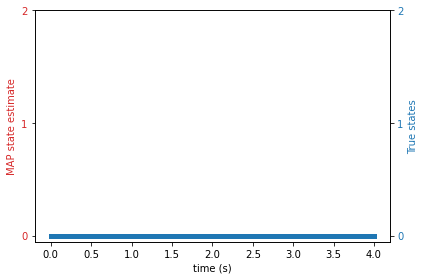

In [22]:
fig, ax1 = plt.subplots()

trajectory_index = 0

t = list(range(len(true_states[trajectory_index])))

color = 'tab:red'
ax1.set_xlabel('time (s)')
ax1.set_ylabel('MAP state estimate', color=color)
ax1.plot(t, np.argmax(state_inference[trajectory_index], axis=1), color=color, linewidth=5)
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_yticks([0, 1, 2])

ax2 = ax1.twinx()  

color = 'tab:blue'
ax2.set_ylabel('True states', color=color)  
ax2.step(t, true_states[trajectory_index], color=color, linewidth=5)
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_yticks([0, 1, 2])

fig.tight_layout()  
plt.show()

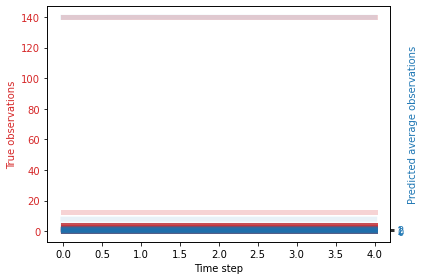

In [23]:
fig, ax1 = plt.subplots()

t = list(range(len(true_states[trajectory_index])))

color = 'tab:red'
ax1.set_xlabel('Time step')
ax1.set_ylabel('True observations', color=color)
ax1.plot(t, X_observations[trajectory_index], color=color, linewidth=5, alpha=0.2)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  

color = 'tab:blue'
ax2.set_ylabel('Predicted average observations', color=color)  
ax2.plot(t, expected_observations[trajectory_index], color=color, linewidth=5, alpha=0.1)
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_yticks([0, 1, 2])

fig.tight_layout()  
plt.show()

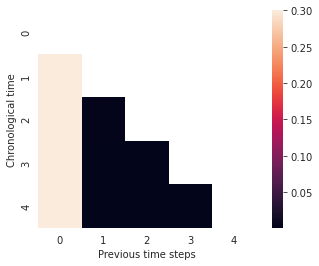

In [24]:
# Visualize the attention weights over time
import seaborn as sns

Attention_weights = []

for w in range(len(attention[0])):
    
    Attention_weights.append(np.vstack((attention[0][w], np.zeros((len(attention[0][-1]) - len(attention[0][w]),1)))))


Attention_weights = np.array(Attention_weights).reshape((len(attention[0][-1]), len(attention[0][-1])))[:state_inference[0].shape[0], :state_inference[0].shape[0]]

mask = np.zeros_like(Attention_weights)

mask[np.triu_indices_from(mask)] = True

with sns.axes_style("white"):
    ax = sns.heatmap(Attention_weights, mask=mask, vmax=.3, square=True)
    ax.set_ylabel('Chronological time')
    ax.set_xlabel('Previous time steps')

# TimeGANs Synthesized Data with ASSM Model

In [31]:
## Newtork Parameters
parameters = dict()

seqlen = 4

# generate the data
assm_df, assm_feat_list = doggo_data_loading(seq_length=seqlen, apply_seq_length=True) 
dataX = doggo_data_timeGANs(assm_df, seq_length=seqlen)

parameters['hidden_dim'] = len(dataX[0][0,:]) * 4
parameters['num_layers'] = 3 # started with: 2 (has to be at least 2!)
parameters['iterations'] = 10000 # started with: 1000, low as 10
parameters['batch_size'] = 128 # started with: 64, low as 2
parameters['module_name'] = 'gru'   # Other options: 'lstm' or 'lstmLN'
parameters['z_dim'] = len(dataX[0][0,:]) 

# Synthetic Data Generation
dataX_hat = timegan(dataX, parameters)   

print('Parameters are ' + str(parameters))

feature size:  42
Joined SIZE:  (49425, 47)
doggo_data_timeGANs dataframe shape post:  (49425, 42)
Start Embedding Network Training
step: 0, e_loss: 0.4206
step: 1000, e_loss: 0.2524
step: 2000, e_loss: 0.2049
step: 3000, e_loss: 0.1675
step: 4000, e_loss: 0.1486
step: 5000, e_loss: 0.1303
step: 6000, e_loss: 0.1098
step: 7000, e_loss: 0.096
step: 8000, e_loss: 0.0854
step: 9000, e_loss: 0.0833
Finish Embedding Network Training
Start Training with Supervised Loss Only
step: 0, s_loss: 0.3235
step: 1000, s_loss: 0.0306
step: 2000, s_loss: 0.0224
step: 3000, s_loss: 0.0197
step: 4000, s_loss: 0.0171
step: 5000, s_loss: 0.0151
step: 6000, s_loss: 0.0147
step: 7000, s_loss: 0.0146
step: 8000, s_loss: 0.013
step: 9000, s_loss: 0.0132
Finish Training with Supervised Loss Only
Start Joint Training
step: 0, d_loss: 2.1417, g_loss_u: 0.6494, g_loss_s: 0.0628, g_loss_v: 0.5292, e_loss_t0: 0.1504
step: 1000, d_loss: 1.1875, g_loss_u: 1.883, g_loss_s: 0.0303, g_loss_v: 0.0655, e_loss_t0: 0.0514
st

In [8]:
# FYI - can't get entire DF to run through without ASSM collapsing.  Max on minimum params is 21,000, larger params 29,400
syn_df = prep_synth_data(dataX_hat)
X_observations_syn, true_states_syn = generate_doggo_trajectory_syn(syn_df[0:17300], feats=assm_feat_list)

# TODO adjust 0:20000 to as high as possible
# keep adding categories!

In [9]:
trajectory_index_syn = 3

true_states_syn[trajectory_index_syn]

[0.11641308665275574,
 0.04035574197769165,
 0.04468816518783569,
 0.042920321226119995]

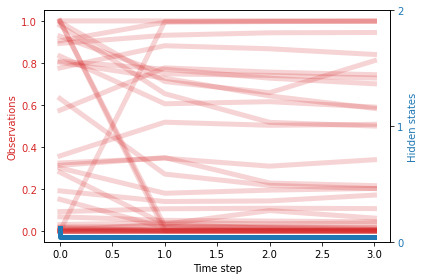

In [10]:
# Visualizing the hidden state data trajectories
fig, ax1 = plt.subplots()

t_syn = list(range(len(true_states_syn[trajectory_index_syn])))

color = 'tab:red'
ax1.set_xlabel('Time step')
ax1.set_ylabel('Observations', color=color)
ax1.plot(t_syn, X_observations_syn[trajectory_index_syn], color=color, linewidth=5, alpha=0.2)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  

color = 'tab:blue'
ax2.set_ylabel('Hidden states', color=color)  
ax2.step(t_syn, true_states_syn[trajectory_index_syn], color=color, linewidth=5)
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_yticks([0, 1, 2])

fig.tight_layout()  
plt.show()

In [12]:
feat_num = len(assm_feat_list)
print(feat_num)
model_syn = attentive_state_space_model(num_states=4,
                              maximum_seq_length=30, 
                              input_dim=feat_num-5,  # started with: 6. tried 10, but broke, but that was original, adjust for how many features used in data
                              rnn_type='LSTM',
                              latent=True,
                              generative=True,
                              num_iterations=50,   # started with: 5
                              num_epochs=3,  # started with: 2
                              batch_size=100,  # started with: 10
                              learning_rate=5*1e-4, 
                              num_rnn_hidden=100,  # started with: 5
                              num_rnn_layers=1,
                              dropout_keep_prob=None,
                              num_out_hidden=100,  # started with: 5
                              num_out_layers=1)

42
Instructions for updating:
This class is equivalent as tf.keras.layers.SimpleRNNCell, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
This class is equivalent as tf.keras.layers.LSTMCell, and will be replaced by that in Tensorflow 2.0.


In [13]:
start_time = time.time()

model_syn.fit(X_observations_syn)

elapsed_time = time.time() - start_time
print(f"Elapsed time to make predictions: {elapsed_time:.3f} seconds")

TensorFlow version : >= 1.0
---------------------------
Instructions for updating:
Please use `keras.layers.RNN(cell, unroll=True)`, which is equivalent to this API
Epoch 0 	----- 	Batch 0 	----- 	Log-Likelihood -1.681830e+05
Epoch 0 	----- 	Batch 1 	----- 	Log-Likelihood -1.677837e+05
Epoch 0 	----- 	Batch 2 	----- 	Log-Likelihood -1.677916e+05
Epoch 0 	----- 	Batch 3 	----- 	Log-Likelihood -1.559513e+05
Epoch 0 	----- 	Batch 4 	----- 	Log-Likelihood -1.635646e+05
Epoch 0 	----- 	Batch 5 	----- 	Log-Likelihood -1.568335e+05
Epoch 0 	----- 	Batch 6 	----- 	Log-Likelihood -1.583527e+05
Epoch 0 	----- 	Batch 7 	----- 	Log-Likelihood -1.569983e+05
Epoch 0 	----- 	Batch 8 	----- 	Log-Likelihood -1.469210e+05
Epoch 0 	----- 	Batch 9 	----- 	Log-Likelihood -1.602735e+05
Epoch 0 	----- 	Batch 10 	----- 	Log-Likelihood -1.746682e+05
Epoch 0 	----- 	Batch 11 	----- 	Log-Likelihood -1.524952e+05
Epoch 0 	----- 	Batch 12 	----- 	Log-Likelihood -1.591466e+05
Epoch 0 	----- 	Batch 13 	----- 	Log-Li

In [14]:
model_syn.initial_probabilities

array([0.38367253, 0.61632747])

In [15]:
model_syn.transition_matrix

array([[0.68915401, 0.31084599],
       [0.15426931, 0.84573069]])

In [16]:
model_syn.state_means.T 

array([[0.30125465, 0.29290551],
       [0.40090061, 0.58287567],
       [0.45550789, 0.52978913],
       [0.02366484, 0.02511545],
       [0.20313607, 0.27695905],
       [0.44404608, 0.37638128],
       [0.0509593 , 0.16341717],
       [0.1032743 , 0.28187275],
       [0.12051808, 0.22891161],
       [0.66543565, 0.73554025],
       [0.60089191, 0.73355122],
       [0.64157436, 0.47229232],
       [0.59473742, 0.6445152 ],
       [0.19671805, 0.40040217],
       [0.14885071, 0.25619556],
       [0.28050632, 0.44028028],
       [0.06894256, 0.0512051 ],
       [0.60809034, 0.35671677],
       [0.5019301 , 0.38542161],
       [0.92761231, 0.97032911],
       [0.23569959, 0.15420051],
       [0.40576012, 0.47038687],
       [0.33365342, 0.47454591],
       [0.99997315, 0.88044047],
       [0.98439696, 0.97104183],
       [0.92954351, 0.96352837],
       [0.51558712, 0.75873045],
       [0.73069008, 0.76789427],
       [0.0940742 , 0.08482737],
       [0.16936106, 0.05864899],
       [0.

In [17]:
model_syn.state_covars

array([[[ 3.68511382e-02, -7.99288644e-03, -1.36759464e-03, ...,
         -3.82217760e-04, -1.21355211e-02,  6.41842974e-06],
        [-7.99288644e-03,  6.91920467e-02,  2.12806062e-02, ...,
          1.92785326e-02,  2.07699044e-02, -1.49567247e-05],
        [-1.36759464e-03,  2.12806062e-02,  8.42803171e-02, ...,
          2.11841279e-02,  3.54349985e-02, -4.61277474e-06],
        ...,
        [-3.82217760e-04,  1.92785326e-02,  2.11841279e-02, ...,
          1.05074106e-01, -5.35671225e-03,  2.09388880e-06],
        [-1.21355211e-02,  2.07699044e-02,  3.54349985e-02, ...,
         -5.35671225e-03,  1.02202280e-01,  1.15317815e-05],
        [ 6.41842974e-06, -1.49567247e-05, -4.61277474e-06, ...,
          2.09388880e-06,  1.15317815e-05,  1.25103891e-06]],

       [[ 4.50270952e-02, -2.11004834e-02, -1.89284543e-02, ...,
         -1.71562579e-02, -1.69813990e-02,  4.92535261e-03],
        [-2.11004834e-02,  6.05146684e-02,  3.93437648e-02, ...,
          2.80789633e-02,  2.50744418e

In [18]:
X_observations_syn[3]

array([[8.08310449e-01, 3.24659258e-01, 1.92043722e-01, 1.51882976e-01,
        8.02843332e-01, 3.13304454e-01, 3.00900012e-01, 1.79394484e-02,
        9.78680491e-01, 5.75184822e-01, 7.76460290e-01, 9.35187638e-02,
        8.92906606e-01, 6.87096417e-02, 6.30819798e-01, 3.58152568e-01,
        2.80515373e-01, 1.00386739e-02, 8.32951248e-01, 8.64267349e-07,
        2.52693892e-04, 1.17191672e-02, 3.19155455e-02, 9.99835193e-01,
        5.10653853e-03, 1.55657530e-04, 9.05369878e-01, 1.59797072e-03,
        9.27061379e-01, 8.94069672e-07, 3.81916761e-04, 9.99818087e-01,
        2.05982327e-02, 1.48385763e-03, 9.94370639e-01, 8.45700502e-04,
        9.99679804e-01],
       [7.70275474e-01, 3.47273827e-01, 1.41520441e-01, 1.65956616e-02,
        7.27591932e-01, 3.50341201e-01, 1.80711716e-01, 6.55013323e-03,
        6.54005170e-01, 7.76812077e-01, 8.81921768e-01, 1.06919080e-01,
        9.31640267e-01, 5.20794988e-02, 2.71795601e-01, 5.18475652e-01,
        3.31976414e-02, 2.27427483e-03,

In [19]:
start_time = time.time()

predict_idx_syn = 0
state_inference_syn, expected_observations_syn, attention_syn = model_syn.predict([X_observations_syn[predict_idx_syn]])

elapsed_time = time.time() - start_time
print(f"Elapsed time to make predictions: {elapsed_time:.3f} seconds")

Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from ./mlaimRNN_model
Elapsed time to make predictions: 3.843 seconds


In [20]:
np.argmax(state_inference_syn[predict_idx_syn], axis=1)

array([1, 1, 1, 1])

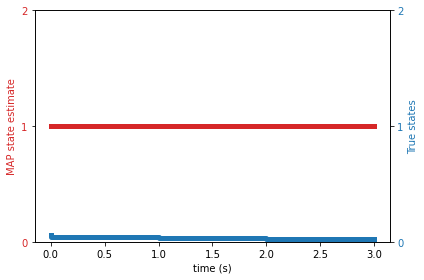

In [21]:
fig, ax1 = plt.subplots()
trajectory_index_syn = 0
t_syn = list(range(len(true_states_syn[trajectory_index_syn])))
color = 'tab:red'
ax1.set_xlabel('time (s)')
ax1.set_ylabel('MAP state estimate', color=color)
ax1.plot(t_syn, np.argmax(state_inference_syn[trajectory_index_syn], axis=1), color=color, linewidth=5)
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_yticks([0, 1, 2])
ax2 = ax1.twinx()  
color = 'tab:blue'
ax2.set_ylabel('True states', color=color)  
ax2.step(t_syn, true_states_syn[trajectory_index_syn], color=color, linewidth=5)
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_yticks([0, 1, 2])
fig.tight_layout()  
plt.show()

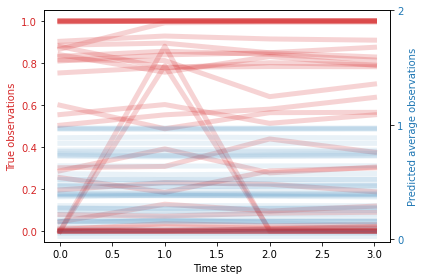

In [22]:
fig, ax1 = plt.subplots()
t_syn = list(range(len(true_states_syn[trajectory_index_syn])))
color = 'tab:red'
ax1.set_xlabel('Time step')
ax1.set_ylabel('True observations', color=color)
ax1.plot(t_syn, X_observations_syn[trajectory_index_syn], color=color, linewidth=5, alpha=0.2)
ax1.tick_params(axis='y', labelcolor=color)
ax2 = ax1.twinx()  
color = 'tab:blue'
ax2.set_ylabel('Predicted average observations', color=color)  
ax2.plot(t_syn, expected_observations_syn[trajectory_index_syn], color=color, linewidth=5, alpha=0.1)
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_yticks([0, 1, 2])
fig.tight_layout()  
plt.show()

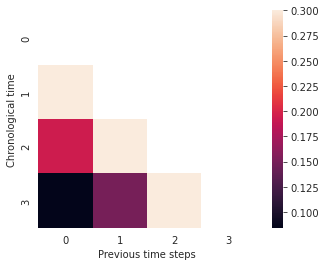

In [23]:
# Visualize the attention weights over time
import seaborn as sns
Attention_weights_syn = []
for w in range(len(attention_syn[0])):
    Attention_weights_syn.append(np.vstack((attention_syn[0][w], np.zeros((len(attention_syn[0][-1]) - len(attention_syn[0][w]),1)))))
Attention_weights_syn = np.array(Attention_weights_syn).reshape((len(attention_syn[0][-1]), len(attention_syn[0][-1])))[:state_inference_syn[0].shape[0], :state_inference_syn[0].shape[0]]
mask_syn = np.zeros_like(Attention_weights_syn)
mask_syn[np.triu_indices_from(mask_syn)] = True
with sns.axes_style("white"):
    ax = sns.heatmap(Attention_weights_syn, mask=mask_syn, vmax=.3, square=True)
    ax.set_ylabel('Chronological time')
    ax.set_xlabel('Previous time steps')

# Using TimeGANs to Oversample Minority Data Class

In [5]:
start_time = time.time()

dataX_min = oversamp_minority_data(gan_df, seqlen=seqlen)

elapsed_time = time.time() - start_time
print(f"Elapsed time to pull up data: {elapsed_time:.3f} seconds")

doggo_data_timeGANs dataframe shape post:  (8172, 42)
minority doggo dataset is ready
Elapsed time to pull up data: 0.016 seconds


In [6]:
## Main Parameters
# Experiments iterations
Iteration = 2 # started with: 1
Sub_Iteration = 3 # started with: 2

## Newtork Parameters
parameters_min = dict()

parameters_min['hidden_dim'] = len(dataX_min[0][0,:]) * 4
parameters_min['num_layers'] = 3 # started with: 2 (has to be at least 2!)
parameters_min['iterations'] = 10000 # started with: 1000, low as 10
parameters_min['batch_size'] = 128 # started with: 64, low as 2
parameters_min['module_name'] = 'gru'   # Other options: 'lstm' or 'lstmLN'
parameters_min['z_dim'] = len(dataX_min[0][0,:]) 

print('Minority class parameters are ' + str(parameters_min))

## Experiments
# Output Initialization
Discriminative_Score_min = list()
Predictive_Score_min = list()

Minority class parameters are {'hidden_dim': 168, 'num_layers': 3, 'iterations': 10000, 'batch_size': 128, 'module_name': 'gru', 'z_dim': 42}


In [7]:
# Run TimeGANs model
# if testing a supervised loss is zero, will error out - need more rows in sequence
print('Start iterations') 

start_time = time.time()

# Each Iteration
for it in range(Iteration):

    # Synthetic Data Generation
    dataX_hat_min = timegan(dataX_min, parameters_min)   
    print('Finish Synthetic Data Generation')
    
    elapsed_time = time.time() - start_time
    print(f"Elapsed time to make predictions: {elapsed_time:.3f} seconds")

    ## Performance Metrics
    
    # 1. Discriminative Score
    Acc_min = list()
    for tt in range(Sub_Iteration):
        Temp_Disc_min = discriminative_score_metrics(dataX_min, dataX_hat_min)
        Acc_min.append(Temp_Disc_min)
        
    elapsed_time = time.time() - start_time
    print(f"Elapsed time to make predictions: {elapsed_time:.3f} seconds")
    
    Discriminative_Score_min.append(np.mean(Acc_min))
    
    # 2. Predictive Performance
    MAE_All_min = list()
    
    for tt in range(Sub_Iteration):
        # print(f'min data solvency check predictive score metrics length: {len(predictive_score_metrics(dataX_min, dataX_hat_min))}')
        MAE_All_min.append(predictive_score_metrics(dataX_min, dataX_hat_min))
        
    elapsed_time = time.time() - start_time
    print(f"Elapsed time to make predictions: {elapsed_time:.3f} seconds")
        
    Predictive_Score_min.append(np.mean(MAE_All_min))  
    
print('Finish TimeGAN iterations')
elapsed_time = time.time() - start_time
print(f"Elapsed time to make predictions: {elapsed_time:.3f} seconds")

Start iterations
Instructions for updating:
This class is equivalent as tf.keras.layers.GRUCell, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
This class is equivalent as tf.keras.layers.StackedRNNCells, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Start Embedding Network Training
step: 0, e_loss: 0.4198
step: 1000, e_loss: 0.2447
step: 2000, e_loss: 0.2013
step: 3000, e_loss: 0.1495
step: 4000, e_loss: 0.1219
step: 5000, e_loss: 0.0937
step: 6000, e_loss: 0.0807
step: 7000, e_loss: 0.0709
step: 8000, e_loss: 0.0619
step: 9000, e_loss: 0.0547
Finish Embedding Network Training
Start Training with Supervised Loss Only
step: 0, s_loss: 0.3701
step: 1000, s_loss: 0.0444
step: 2000, s_loss: 0.0363
st

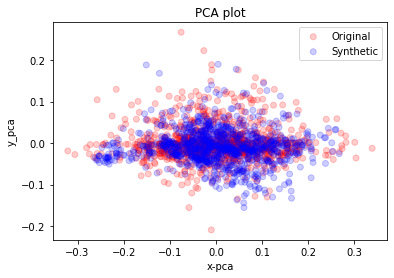

In [8]:
PCA_Analysis(dataX_min, dataX_hat_min)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 2000 samples in 0.001s...
[t-SNE] Computed neighbors for 2000 samples in 0.070s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2000
[t-SNE] Computed conditional probabilities for sample 2000 / 2000
[t-SNE] Mean sigma: 0.015935
[t-SNE] KL divergence after 250 iterations with early exaggeration: 65.283485
[t-SNE] KL divergence after 300 iterations: 1.059177


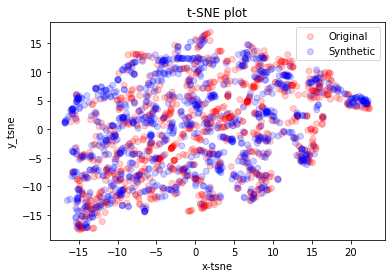

In [9]:
tSNE_Analysis(dataX_min, dataX_hat_min)

In [10]:
# Print Results
print('Minority class discriminative Score - Mean: ' + str(np.round(np.mean(Discriminative_Score_min),4)) + ', Std: ' + str(np.round(np.std(Discriminative_Score_min),4)))
print('Minority class  predictive Score - Mean: ' + str(np.round(np.mean(Predictive_Score_min),4)) + ', Std: ' + str(np.round(np.std(Predictive_Score_min),4)))

Minority class discriminative Score - Mean: 0.4824, Std: 0.0132
Minority class  predictive Score - Mean: 0.4918, Std: 0.0034


In [11]:
print('new dogs: ', len(dataX_hat_min))
print('meet scruffy: ', dataX_hat_min[0])

new dogs:  8168
meet scruffy:  [[9.4636559e-02 8.9406967e-08 4.4288036e-01 1.4350295e-01 1.0326147e-02
  6.7306459e-03 9.6114576e-02 4.2099994e-01 6.0533553e-02 5.2194601e-01
  9.0747857e-01 6.7277062e-01 7.5607961e-01 1.3619900e-01 1.3155100e-01
  9.4158518e-01 9.9952221e-02 2.9412848e-01 9.9998975e-01 8.1334865e-01
  1.0000000e+00 9.8858798e-01 0.0000000e+00 1.0006410e-01 1.0000000e+00
  9.9999994e-01 1.0000000e+00 9.9568629e-01 8.9747781e-01 9.4389319e-03
  0.0000000e+00 0.0000000e+00 2.0861626e-07 3.9552715e-01 4.2731345e-01
  9.9999470e-01 1.0000000e+00 1.9431114e-04 1.9154128e-01 5.9604645e-08
  5.1424712e-02 9.9984103e-01]
 [7.8942239e-02 0.0000000e+00 3.9860800e-01 1.1461109e-01 1.7772317e-02
  1.6312137e-01 1.9366762e-01 4.2411566e-01 7.5538427e-02 7.5847411e-01
  3.7000418e-01 7.7516329e-01 7.4784982e-01 3.8600081e-01 2.7195770e-01
  2.9082969e-01 5.1683664e-02 3.5045654e-02 9.9999988e-01 8.1758147e-01
  1.0000000e+00 1.6391277e-05 9.9973607e-01 1.6271186e-01 1.0000000e+00
  

In [12]:
seqlen = 4

# generate the data
orig_df, orig_feat_list = doggo_data_loading(seq_length=seqlen, apply_seq_length=True) 
orig_feat_num = len(orig_feat_list)
orig_df.head(10)

feature size:  42
Joined SIZE:  (49425, 47)


,dog_id,hs_health_conditions_cancer,hs_general_health,hs_recent_hospitalization,db_excitement_level_before_walk,db_excitement_level_before_car_ride,db_aggression_level_approached_while_eating,db_aggression_level_on_leash_unknown_dog,db_fear_level_loud_noises,db_fear_level_unknown_human_touch,...,mp_flea_and_tick_treatment,mp_heartworm_preventative,hs_condition_type,hs_diagnosis_month,hs_diagnosis_year,hs_follow_up_ongoing,dd_combined_main_breed,free_fed,surg_hospital,state
4,9,0,3,0,4.0,4.0,0.0,2.0,4.0,1.0,...,0,1,3.0,1.0,2013.0,0,140.0,0,1.0,0
5,9,0,3,0,4.0,4.0,0.0,2.0,4.0,1.0,...,0,1,7.0,1.0,2013.0,1,140.0,0,1.0,0
6,9,0,3,0,4.0,4.0,0.0,2.0,4.0,1.0,...,0,1,18.0,9.0,2014.0,0,140.0,0,3.0,0
7,9,0,3,0,4.0,4.0,0.0,2.0,4.0,1.0,...,0,1,17.0,9.0,2019.0,0,140.0,0,1.0,0
8,9,0,3,0,4.0,4.0,0.0,2.0,4.0,1.0,...,0,1,4.0,8.0,2020.0,1,140.0,0,1.0,0
15,21,0,3,0,2.0,3.0,0.0,4.0,2.0,1.0,...,1,1,4.0,8.0,2010.0,0,243.0,0,1.0,0
16,21,0,3,0,2.0,3.0,0.0,4.0,2.0,1.0,...,1,1,3.0,2.0,2013.0,0,243.0,0,1.0,0
17,21,0,3,0,2.0,3.0,0.0,4.0,2.0,1.0,...,1,1,18.0,4.0,2013.0,0,243.0,0,1.0,0
18,21,0,3,0,2.0,3.0,0.0,4.0,2.0,1.0,...,1,1,16.0,3.0,2014.0,1,243.0,0,1.0,0
19,21,0,3,0,2.0,3.0,0.0,4.0,2.0,1.0,...,1,1,18.0,1.0,2015.0,0,243.0,0,1.0,0


In [19]:
# FYI - can't get entire DF to run through without ASSM collapsing.  Max on minimum params is 21,000, larger params 29,400
# undersample the majority case. keep all minority case:
# TODO come back to this!

# combine and form data for model - combine new datapoints with existing dataset
X_observations_comb, true_states_comb = generate_doggo_trajectory_comb(orig_df[0:17000], dataX_hat_min, feats=orig_feat_list)

# TODO adjust 0:20000 to as high as possible
# keep adding categories!

sync_df size:  (32672, 43)
orig_df size:  (17000, 43)
combined df size:  (49672, 43)


In [20]:
trajectory_index_comb = 3

true_states_comb[trajectory_index_comb]

[0.0, 0.0, 0.0, 0.0, 0.0]

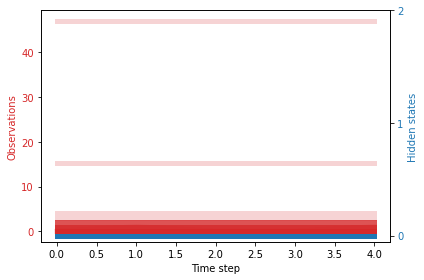

In [21]:
# Visualizing the hidden state data trajectories
fig, ax1 = plt.subplots()

t_comb = list(range(len(true_states_comb[trajectory_index_comb])))

color = 'tab:red'
ax1.set_xlabel('Time step')
ax1.set_ylabel('Observations', color=color)
ax1.plot(t_comb, X_observations_comb[trajectory_index_comb], color=color, linewidth=5, alpha=0.2)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  

color = 'tab:blue'
ax2.set_ylabel('Hidden states', color=color)  
ax2.step(t_comb, true_states_comb[trajectory_index_comb], color=color, linewidth=5)
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_yticks([0, 1, 2])

fig.tight_layout()  
plt.show()

In [22]:
dims = orig_feat_num
print(dims)
model_comb = attentive_state_space_model(num_states=4,
                              maximum_seq_length=30, 
                              input_dim=dims, # 6,  # started with: 6. tried 10, but broke, but that was original, adjust for how many features used in data
                              rnn_type='LSTM',
                              latent=True,
                              generative=True,
                              num_iterations=50,   # started with: 5
                              num_epochs=3,  # started with: 2
                              batch_size=100,  # started with: 10
                              learning_rate=5*1e-4, 
                              num_rnn_hidden=100,  # started with: 5
                              num_rnn_layers=1,
                              dropout_keep_prob=None,
                              num_out_hidden=100,  # started with: 5
                              num_out_layers=1)

42
Instructions for updating:
This class is equivalent as tf.keras.layers.SimpleRNNCell, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
This class is equivalent as tf.keras.layers.LSTMCell, and will be replaced by that in Tensorflow 2.0.


In [23]:
model_comb.fit(X_observations_comb)

TensorFlow version : >= 1.0
---------------------------
Instructions for updating:
Please use `keras.layers.RNN(cell, unroll=True)`, which is equivalent to this API
Epoch 0 	----- 	Batch 0 	----- 	Log-Likelihood -1.396649e+02
Epoch 0 	----- 	Batch 1 	----- 	Log-Likelihood -1.381706e+02
Epoch 0 	----- 	Batch 2 	----- 	Log-Likelihood -1.279802e+02
Epoch 0 	----- 	Batch 3 	----- 	Log-Likelihood -1.186122e+02
Epoch 0 	----- 	Batch 4 	----- 	Log-Likelihood -1.222402e+02
Epoch 0 	----- 	Batch 5 	----- 	Log-Likelihood -1.274587e+02
Epoch 0 	----- 	Batch 6 	----- 	Log-Likelihood -1.216164e+02
Epoch 0 	----- 	Batch 7 	----- 	Log-Likelihood -1.221703e+02
Epoch 0 	----- 	Batch 8 	----- 	Log-Likelihood -1.200939e+02
Epoch 0 	----- 	Batch 9 	----- 	Log-Likelihood -1.217922e+02
Epoch 0 	----- 	Batch 10 	----- 	Log-Likelihood -1.213773e+02
Epoch 0 	----- 	Batch 11 	----- 	Log-Likelihood -1.127119e+02
Epoch 0 	----- 	Batch 12 	----- 	Log-Likelihood -1.242531e+02
Epoch 0 	----- 	Batch 13 	----- 	Log-Li

In [24]:
model_comb.initial_probabilities

array([0.74640271, 0.25359729])

In [25]:
model_comb.transition_matrix

array([[9.99795518e-01, 2.04482251e-04],
       [1.32820692e-03, 9.98671793e-01]])

In [26]:
model_comb.state_means.T 

array([[3.33716668e-01, 2.40690333e+00],
       [2.99779941e-02, 3.56472414e-02],
       [5.19223714e-01, 2.22027814e+00],
       [5.32318504e-01, 2.15825958e+00],
       [1.81418978e-02, 9.98015029e-02],
       [2.82052903e-01, 1.14920319e+00],
       [4.01907776e-01, 1.56489738e+00],
       [1.48834065e-01, 6.36311218e-01],
       [1.86542740e-01, 9.35693068e-01],
       [2.03097464e-01, 8.36785841e-01],
       [6.83858700e-01, 2.79099363e+00],
       [6.91866984e-01, 2.70675223e+00],
       [5.30065757e-01, 2.17615645e+00],
       [6.39953856e-01, 2.34195841e+00],
       [3.35169658e-01, 1.50975660e+00],
       [2.61275412e-01, 1.05047447e+00],
       [3.60578115e-01, 1.63755704e+00],
       [3.85762937e-02, 2.00106250e-01],
       [4.97075407e-01, 1.49466098e+00],
       [5.22576879e-01, 1.03022820e+01],
       [9.49697856e-01, 9.61454740e-01],
       [1.70657385e-01, 2.00286249e-01],
       [5.11992882e-01, 1.47660138e+00],
       [4.77282254e-01, 5.14183511e+00],
       [9.345695

In [27]:
model_comb.state_covars

array([[[ 4.33812244e-02,  3.15262543e-03, -2.76251236e-03, ...,
          5.39202593e-03, -3.96864800e-03, -3.81808902e-03],
        [ 3.15262543e-03,  2.31830259e-02, -2.34432828e-03, ...,
         -1.73622969e-03,  8.00828641e-03,  4.84281604e-04],
        [-2.76251236e-03, -2.34432828e-03,  7.98215542e-02, ...,
          1.08165142e-03, -3.13024028e-03, -3.89475158e-02],
        ...,
        [ 5.39202593e-03, -1.73622969e-03,  1.08165142e-03, ...,
          5.60656730e-02, -5.06987109e-03, -9.74864788e-03],
        [-3.96864800e-03,  8.00828641e-03, -3.13024028e-03, ...,
         -5.06987109e-03,  5.61554192e-02,  4.96599290e-03],
        [-3.81808902e-03,  4.84281604e-04, -3.89475158e-02, ...,
         -9.74864788e-03,  4.96599290e-03,  2.44062683e-01]],

       [[ 1.06072758e+00,  2.31940824e-02, -1.80452023e-01, ...,
         -2.41884320e-03,  1.28087625e-02,  3.16364106e-02],
        [ 2.31940824e-02,  3.43774294e-02, -1.63760948e-03, ...,
          8.64461477e-04,  7.78198632e

In [28]:
X_observations_comb[3]

array([[ 4.  ,  0.  ,  1.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  2.  ,
         0.  ,  2.  ,  1.  ,  2.  ,  2.  ,  0.  ,  0.  ,  0.  ,  1.  ,
         1.  , 15.25,  1.  ,  0.  ,  1.  ,  2.  ,  1.  ,  1.  ,  1.  ,
         2.  ,  3.  ,  0.  ,  0.  ,  1.  ,  0.  ,  2.  ,  0.  ,  1.  ,
         1.  ,  0.  , 47.  ,  0.  ,  1.  ,  0.  ],
       [ 4.  ,  0.  ,  1.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  2.  ,
         0.  ,  2.  ,  1.  ,  2.  ,  2.  ,  0.  ,  0.  ,  0.  ,  1.  ,
         1.  , 15.25,  1.  ,  0.  ,  1.  ,  2.  ,  1.  ,  1.  ,  1.  ,
         2.  ,  3.  ,  0.  ,  0.  ,  1.  ,  0.  ,  2.  ,  0.  ,  1.  ,
         1.  ,  1.  , 47.  ,  0.  ,  1.  ,  0.  ],
       [ 4.  ,  0.  ,  1.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  2.  ,
         0.  ,  2.  ,  1.  ,  2.  ,  2.  ,  0.  ,  0.  ,  0.  ,  1.  ,
         1.  , 15.25,  1.  ,  0.  ,  1.  ,  2.  ,  1.  ,  1.  ,  1.  ,
         2.  ,  3.  ,  0.  ,  0.  ,  1.  ,  0.  ,  2.  ,  0.  ,  1.  ,
         1.  ,  0.  , 47.  ,  0.  ,  1.  ,  0.

In [29]:
predict_idx_comb = 0
state_inference_comb, expected_observations_comb, attention_comb = model_comb.predict([X_observations_comb[predict_idx_comb]])

Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from ./mlaimRNN_model


In [30]:
np.argmax(state_inference_comb[predict_idx_comb], axis=1)

array([1, 1, 1, 1, 1])

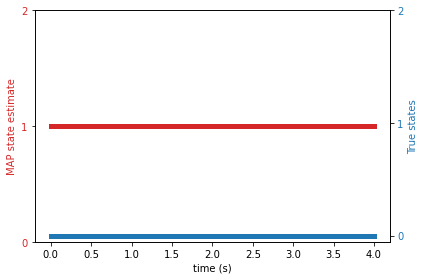

In [31]:
fig, ax1 = plt.subplots()
trajectory_index_comb = 0
t_comb = list(range(len(true_states_comb[trajectory_index_comb])))
color = 'tab:red'
ax1.set_xlabel('time (s)')
ax1.set_ylabel('MAP state estimate', color=color)
ax1.plot(t_comb, np.argmax(state_inference_comb[trajectory_index_comb], axis=1), color=color, linewidth=5)
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_yticks([0, 1, 2])
ax2 = ax1.twinx()  
color = 'tab:blue'
ax2.set_ylabel('True states', color=color)  
ax2.step(t_comb, true_states_comb[trajectory_index_comb], color=color, linewidth=5)
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_yticks([0, 1, 2])
fig.tight_layout()  
plt.show()

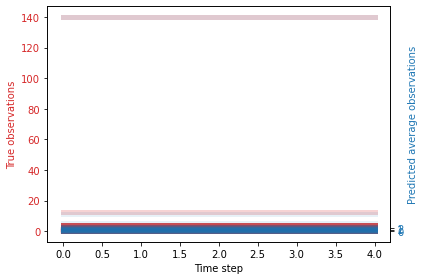

In [32]:
fig, ax1 = plt.subplots()
t_comb = list(range(len(true_states_comb[trajectory_index_comb])))
color = 'tab:red'
ax1.set_xlabel('Time step')
ax1.set_ylabel('True observations', color=color)
ax1.plot(t_comb, X_observations_comb[trajectory_index_comb], color=color, linewidth=5, alpha=0.2)
ax1.tick_params(axis='y', labelcolor=color)
ax2 = ax1.twinx()  
color = 'tab:blue'
ax2.set_ylabel('Predicted average observations', color=color)  
ax2.plot(t_comb, expected_observations_comb[trajectory_index_comb], color=color, linewidth=5, alpha=0.1)
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_yticks([0, 1, 2])
fig.tight_layout()  
plt.show()

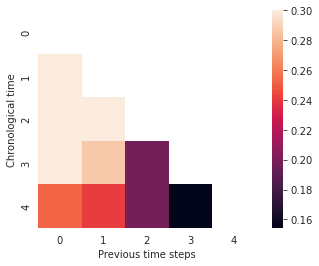

In [33]:
# Visualize the attention weights over time
import seaborn as sns
Attention_weights_comb = []
for w in range(len(attention_comb[0])):
    Attention_weights_comb.append(np.vstack((attention_comb[0][w], np.zeros((len(attention_comb[0][-1]) - len(attention_comb[0][w]),1)))))
Attention_weights_comb = np.array(Attention_weights_comb).reshape((len(attention_comb[0][-1]), len(attention_comb[0][-1])))[:state_inference_comb[0].shape[0], :state_inference_comb[0].shape[0]]
mask_comb = np.zeros_like(Attention_weights_comb)
mask_comb[np.triu_indices_from(mask_comb)] = True
with sns.axes_style("white"):
    ax = sns.heatmap(Attention_weights_comb, mask=mask_comb, vmax=.3, square=True)
    ax.set_ylabel('Chronological time')
    ax.set_xlabel('Previous time steps')

# HIDDEN MARKOV MODEL (HMM)

In [36]:
hmm_model = HMM(num_states = 4)
X_new_observations, new_true_states = generate_doggo_trajectory(assm_df[17000:24000], feats=assm_feat_list)
len(X_new_observations)

start_time = time.time()

hmm_model.fit(X_observations)

elapsed_time = time.time() - start_time
print(f"Elapsed time to run HMM model: {elapsed_time:.3f} seconds")

start_time = time.time()

z2 = hmm_model.predict(X_new_observations)

elapsed_time = time.time() - start_time
print(f"Elapsed time to predict with HMM model: {elapsed_time:.3f} seconds")

z2

Elapsed time to run HMM model: 8.325 seconds
Elapsed time to predict with HMM model: 0.463 seconds


array([[2.35552666e+00, 1.73877461e-66, 2.15986129e+00, ...,
        3.71425544e-56, 1.12735154e+00, 8.66926745e-02],
       [2.35552666e+00, 1.73877461e-66, 2.15986129e+00, ...,
        3.71425544e-56, 1.12735154e+00, 8.66926745e-02],
       [2.35552666e+00, 1.73877461e-66, 2.15986129e+00, ...,
        3.71425544e-56, 1.12735154e+00, 8.66926745e-02],
       ...,
       [2.35552666e+00, 1.73877461e-66, 2.15986129e+00, ...,
        3.71425544e-56, 1.12735154e+00, 8.66926745e-02],
       [2.35552666e+00, 1.73877461e-66, 2.15986129e+00, ...,
        3.71425544e-56, 1.12735154e+00, 8.66926745e-02],
       [2.35552666e+00, 1.73877461e-66, 2.15986129e+00, ...,
        3.71425544e-56, 1.12735154e+00, 8.66926745e-02]])

In [37]:
sample = hmm_model.hmm_model.sample()
sample

(array([[ 3.66055651e+00,  1.06967783e-03,  3.57067713e+00,
          2.47108834e+00,  4.77794947e-01,  1.43825379e+00,
          1.57823874e+00,  1.30441812e+00,  1.08132050e+00,
          2.37633324e+00,  1.40502384e+00,  2.45511005e+00,
          4.36499444e+00,  3.25745147e+00,  2.52655165e+00,
          6.56450711e-01,  1.92918829e+00,  4.53280829e-01,
          1.36354895e+00,  1.13564873e+01,  9.99174940e-01,
         -1.77009093e-01,  8.83829550e-01,  5.19305274e+00,
          7.00051859e-01,  1.24758910e+00,  7.81605891e-01,
         -4.38607639e-01,  1.89655935e+00,  1.47651064e-01,
          1.71775318e-01,  4.46629169e-01, -3.12376871e-01,
          1.43959696e+00,  9.59499318e-01,  1.16810105e+00,
          1.13660747e+00,  4.05069991e-01,  8.39619220e+01,
          3.63712129e-01,  1.23938758e+00,  4.22470141e-02]]),
 array([1]))

In [38]:
score = hmm_model.hmm_model.score(z2)
score

-71697.22300218203

In [41]:
# 2nd test
X_new_observations2, new_true_states2 = generate_doggo_trajectory(assm_df[24000:31000], feats=assm_feat_list)

# inferred optimal hidden state can be obtained by calling predict()
z3 = hmm_model.predict(X_new_observations2)

z3

array([[2.35552666e+00, 1.73877461e-66, 2.15986129e+00, ...,
        3.71425544e-56, 1.12735154e+00, 8.66926745e-02],
       [2.35552666e+00, 1.73877461e-66, 2.15986129e+00, ...,
        3.71425544e-56, 1.12735154e+00, 8.66926745e-02],
       [2.35552666e+00, 1.73877461e-66, 2.15986129e+00, ...,
        3.71425544e-56, 1.12735154e+00, 8.66926745e-02],
       ...,
       [2.35552666e+00, 1.73877461e-66, 2.15986129e+00, ...,
        3.71425544e-56, 1.12735154e+00, 8.66926745e-02],
       [2.35552666e+00, 1.73877461e-66, 2.15986129e+00, ...,
        3.71425544e-56, 1.12735154e+00, 8.66926745e-02],
       [2.35552666e+00, 1.73877461e-66, 2.15986129e+00, ...,
        3.71425544e-56, 1.12735154e+00, 8.66926745e-02]])

In [42]:
# the score of the model can be calucated by the score() method
score3 = hmm_model.hmm_model.score(z3)
score3

-55529.288612287884